In [1]:
import torch
import pytorch_lightning as pl
from torchvision.utils import save_image

# Import the VAE, LatentDiffusion model, and dataloader helper from your module.
from models.latent_diffusion import VAE, LatentDiffusion, get_dataloader

if __name__ == '__main__':
    # -----------------------------
    # Step 1: Train the VAE
    # -----------------------------
    vae = VAE(latent_dim=16, kl_weight=0.001, lr=1e-3)
    vae_trainer = pl.Trainer(
        max_epochs=20,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else None
    )

    dataloader = get_dataloader(batch_size=128)
    vae_trainer.fit(vae, dataloader)

    # Save some VAE reconstructions for quality verification.
    with torch.no_grad():
        x_sample, _ = next(iter(get_dataloader(batch_size=16)))
        x_sample = x_sample.to(vae.device)
        recon, _, _ = vae(x_sample)
        # Concatenate the original and reconstructed images side by side.
        comparison = torch.cat([x_sample, recon], dim=0)
        save_image(comparison, "vae_reconstructions.png", nrow=16, normalize=True)

    print("VAE training complete. Reconstructions saved to 'vae_reconstructions.png'")

    # -----------------------------
    # Step 2: Train the Latent Diffusion Model
    # -----------------------------
    latent_diffusion = LatentDiffusion(vae, timesteps=1000, beta_start=1e-4, beta_end=0.02, lr=1e-4)
    ldm_trainer = pl.Trainer(
        max_epochs=30,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else None
    )

    ldm_trainer.fit(latent_diffusion, dataloader)

    # -----------------------------
    # Step 3: Generate Samples using the Trained Latent Diffusion Model
    # -----------------------------
    samples = latent_diffusion.sample(num_samples=16, ddim_steps=50)
    save_image(samples, "latent_diffusion_samples.png", nrow=4, normalize=True)
    print("Latent Diffusion training complete. Samples saved to 'latent_diffusion_samples.png'")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 156 K  | train
1 | decoder | Decoder | 123 K  | train
--------------------------------------------
279 K     Tr

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | vae   | VAE        | 279 K  | train
1 | model | LatentUNet | 646 K  | train
---------------------------------------------
646 K     Trainable params
279 K     Non-trainable params
926 K     Total params
3.705     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


VAE training complete. Reconstructions saved to 'vae_reconstructions.png'


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Latent Diffusion training complete. Samples saved to 'latent_diffusion_samples.png'
Generating larger sample grid with different sampling steps...
Generating samples with 10 DDIM steps...
Generating samples with 20 DDIM steps...
Generating samples with 50 DDIM steps...
Generating samples with 100 DDIM steps...
Generating a diverse set of 64 examples...
Generating progressive denoising visualization...
Generation complete! Files saved:
- Individual step samples: latent_diffusion_samples_X_steps.png
- Combined sample grid: latent_diffusion_all_samples.png
- Large diverse sample set: latent_diffusion_large_sample.png
- Progressive denoising visualization: latent_diffusion_denoising_process.png


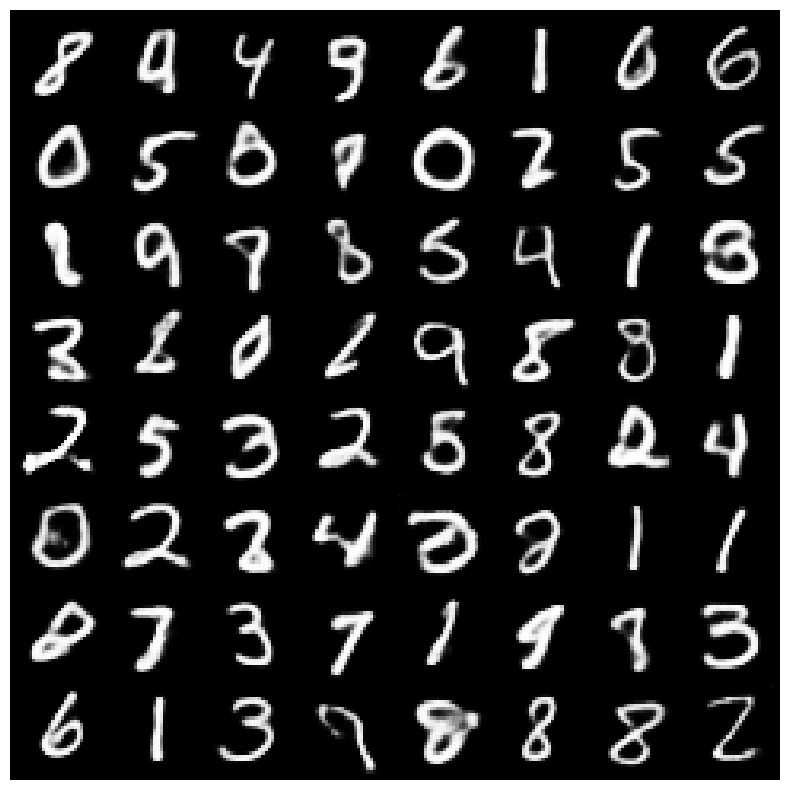

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
img_pil = Image.open("/content/latent_diffusion_large_sample.png")
plt.imshow(img_pil)
plt.axis('off')
plt.show()